In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Generating dataset
def create_dataset(samples, length, vocab):
    dataset = []
    for _ in range(samples):
        source = [random.randint(1, vocab - 1) for _ in range(length)]
        target = source[::-1]  #  reverse
        dataset.append((source, target))
    return dataset

vocab_size = 20
sequence_length = 10
sample_size = 1000
data_samples = create_dataset(sample_size, sequence_length, vocab_size)

In [4]:
class ReversedSeqDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        src, tgt = self.dataset[index]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

data_loader = DataLoader(ReversedSeqDataset(data_samples), batch_size=32, shuffle=True)


In [5]:
class Attention_mechanism(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn_layer = nn.Linear(hidden_dim * 2, hidden_dim)
        self.score_vector = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, hidden_state, encoder_outputs):
        repeat_hidden = hidden_state.repeat(encoder_outputs.size(1), 1, 1).transpose(0, 1)
        combined = torch.cat((repeat_hidden, encoder_outputs), dim=2)
        scores = torch.tanh(self.attn_layer(combined))
        scores = scores @ self.score_vector
        return torch.softmax(scores, dim=1).unsqueeze(1)

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, layers):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, layers, batch_first=True)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, layers, attention):
        super().__init__()
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.LSTM(hidden_dim + embed_dim, hidden_dim, layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, inputs, hidden, cell, encoder_outputs):
        inputs = inputs.unsqueeze(1)
        embedded = self.embedding(inputs)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        rnn_input = torch.cat((embedded, context), dim=2)
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        predictions = self.fc_out(outputs.squeeze(1))
        return predictions, hidden, cell


In [8]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=0.6):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab)
        encoder_outputs, hidden, cell = self.encoder(src)
        input_token = tgt[:, 0]

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            input_token = tgt[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

In [9]:
# Define model hyperparameters
embedding_dim = 256
hidden_dim = 512
num_layers = 2

attention = Attention_mechanism(hidden_dim)
encoder = EncoderRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
decoder = DecoderRNN(vocab_size, embedding_dim, hidden_dim, num_layers, attention)
seq2seq = Seq2SeqModel(encoder, decoder)

In [10]:
# Training setup
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq.parameters(), lr=0.001)
epochs = 10
loss_history = []
accuracy_history = []

In [11]:
# Training setup
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq.parameters(), lr=0.001)
epochs = 10
loss_history = []
accuracy_history = []

# Training loop
for epoch in range(epochs):
    seq2seq.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for src, tgt in data_loader:
        optimizer.zero_grad()
        outputs = seq2seq(src, tgt)
        outputs = outputs[:, 1:].reshape(-1, vocab_size)
        tgt = tgt[:, 1:].reshape(-1)
        
        # Calculate loss
        loss = loss_function(outputs, tgt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.argmax(1)
        correct += (predictions == tgt).sum().item()
        total += tgt.size(0)

    accuracy = correct / total
    accuracy_history.append(accuracy)
    loss_history.append(epoch_loss / len(data_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(data_loader):.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/10, Loss: 2.5581, Accuracy: 0.1884
Epoch 2/10, Loss: 1.9389, Accuracy: 0.3181
Epoch 3/10, Loss: 1.4983, Accuracy: 0.4308
Epoch 4/10, Loss: 1.0915, Accuracy: 0.5863
Epoch 5/10, Loss: 0.7376, Accuracy: 0.7571
Epoch 6/10, Loss: 0.6149, Accuracy: 0.7943
Epoch 7/10, Loss: 0.2402, Accuracy: 0.9370
Epoch 8/10, Loss: 0.1581, Accuracy: 0.9619
Epoch 9/10, Loss: 0.0707, Accuracy: 0.9851
Epoch 10/10, Loss: 0.0715, Accuracy: 0.9859


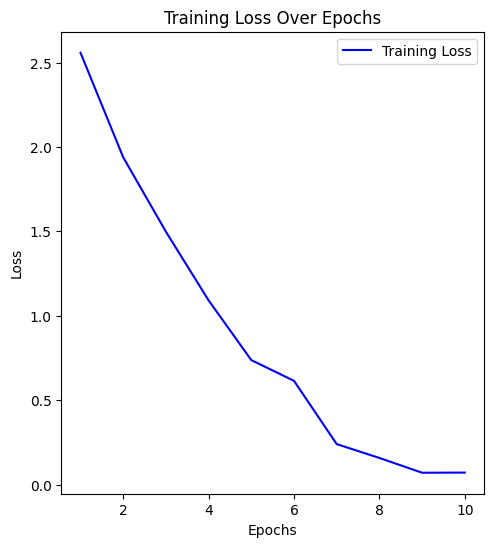

In [12]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

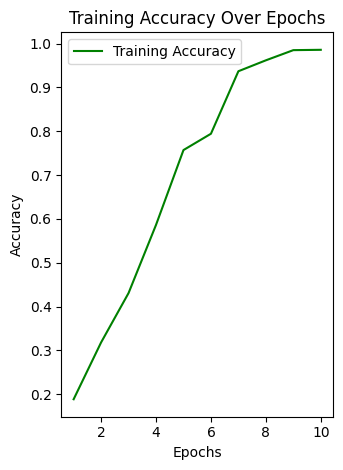

In [13]:
# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy_history, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Model evaluation and sample predictions
seq2seq.eval()  
with torch.no_grad():
    for i, (src, tgt) in enumerate(data_loader): 

        # Get model predictions
        output = seq2seq(src, tgt, teacher_forcing_ratio=0) 
        output = output[:, 1:].reshape(-1, output.shape[2])  # Flatten output
        tgt = tgt[:, 1:].reshape(-1)  # Flatten target

        # Get the predicted token by taking the argmax of output
        predictions = output.argmax(1).view(-1, sequence_length-1)
        
        # Print sample outputs
        print(f'Sample {i + 1}:')
        print(f'Source Sequence: {src[0].numpy()}')
        print(f'Target Sequence: {tgt.view(-1, sequence_length-1)[0].numpy()}')
        print(f'Predicted Sequence: {predictions[0].numpy()}')
        print('-' * 50)  # Separator

        # stop after the first batch to save time
        if i == 0:
            break


Sample 1:
Source Sequence: [11 11  1  9 15 14  3  6 13  7]
Target Sequence: [13  6  3 14 15  9  1 11 11]
Predicted Sequence: [13  6  3 14 15  9  1 11 11]
--------------------------------------------------
